In [1]:
from pandas_profiling import ProfileReport

%pylab inline

import itertools

from lightgbm import LGBMClassifier
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.preprocessing import MinMaxScaler, Normalizer
from scipy.stats import truncnorm as sp_truncnorm
from tqdm import tqdm_notebook as tqdmn
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_uniform, randint as sp_randint
from sklearn.mixture import BayesianGaussianMixture
import gc


sns.set(style='ticks', context='talk')


def truncnorm(a, b, loc, scale):
    a, b = (a - loc) / scale, (b - loc) / scale
    return sp_truncnorm(a=a, b=b, loc=loc, scale=scale)


def plot_confusion_matrix(model, X_test, y_test,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(classification_report(y_test, y_pred, target_names=classes, sample_weight=y_test + 1))
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def plot_feature_importances(model, X):
    indexes = np.argsort(model.feature_importances_)[::-1]
    tmp = pd.Series(data=model.feature_importances_[indexes],
                    index=X.columns[indexes])
    plt.figure(figsize=(16, 10))
    sns.barplot(y=tmp.index, x=tmp.values, orient='h')
    sns.despine()


def preprocess(df, skewness=None, pre_scaler=None, post_scaler=None, normalizer=None):
    df = df.copy()
    if skewness is None:
        skewness = df.skew()
    if pre_scaler is None:
        pre_scaler = MinMaxScaler().fit(df)
    df.loc[:, :] = pre_scaler.transform(df)
    for c in df.columns:
        dfc = df[c]
        if skewness[c] > 0.5:
            df[f'{c}_log'] = np.log1p(dfc)
            df[f'{c}_log'] = np.sqrt(dfc)
        elif skewness[c] < -0.5:
            inv_c = dfc.max() - dfc
            df[f'{c}_log'] = np.log1p(inv_c)
            df[f'{c}_sq'] = np.sqrt(inv_c)
    df = df.fillna(0)
    if post_scaler is None:
        post_scaler = MinMaxScaler().fit(df)
    df.loc[:, :] = post_scaler.transform(df)
    if normalizer is None:
        normalizer = Normalizer().fit(df)
    df.loc[:, :] = normalizer.transform(df)
    return df, skewness, pre_scaler, post_scaler, normalizer

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df['Class'])

In [5]:
report = ProfileReport(df_train_val)
report.to_file('df_train_val_report.html')

In [20]:
df_train, df_val = train_test_split(df_train_val, test_size=0.2, stratify=df_train_val['Class'])

X_train_val = df_train_val.iloc[:, :-1]
y_train_val = df_train_val.iloc[:, -1]
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]
X_val = df_val.iloc[:, :-1]
y_val = df_val.iloc[:, -1]
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

In [8]:
report = ProfileReport(X_train_val)
report.to_file('X_train_val_report.html')

In [21]:
X_train2 = X_train.copy()
y_train2 = y_train.copy()
mask = y_train==1

bgmm = BayesianGaussianMixture(n_components=50)
bgmm.fit(X_train[mask])

for _ in tqdmn(np.arange(int(1/y_train.mean()))):
    tmp = X_train[mask].copy()
    tmp.loc[:, :] = bgmm.sample(len(tmp))[0]
    X_train2 = X_train2.append(tmp)
    y_train2 = y_train2.append(y_train[mask])
    gc.collect()

HBox(children=(IntProgress(value=0, max=578), HTML(value='')))

In [22]:
X_train_val2 = X_train_val.copy()
y_train_val2 = y_train_val.copy()
mask = y_train_val == 1

bgmm = BayesianGaussianMixture(n_components=50)
bgmm.fit(X_train_val[mask])

for _ in tqdmn(np.arange(int(1/y_train_val.mean()))):
    tmp = X_train_val[mask].copy()
    tmp.loc[:, :] = bgmm.sample(len(tmp))[0]
    X_train_val2 = X_train_val2.append(tmp)
    y_train_val2 = y_train_val2.append(y_train_val[mask])
    gc.collect()

HBox(children=(IntProgress(value=0, max=578), HTML(value='')))

In [10]:
X_train_val2, skewness, pre_scaler, post_scaler, normalizer = preprocess(X_train_val2)
X_test, *_ = preprocess(X_test, skewness, pre_scaler, post_scaler, normalizer)

X_train2, skewness, pre_scaler, post_scaler, normalizer = preprocess(X_train2)
X_val, *_ = preprocess(X_val, skewness, pre_scaler, post_scaler, normalizer)

/home/mtambos/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
pp = sns.pairplot(df_train_val)

In [11]:
param_space = {
    'boosting_type': ['dart'],
    'colsample_bytree': sp_uniform(0.5, 0.5),
    'learning_rate': sp_uniform(0.02, 0.04),
    'max_bin': sp_randint(10, 200),
    'n_estimators': sp_randint(10, 100),
    'n_jobs': [-1],
    'num_leaves': sp_randint(3, 20),
    'objective': ['binary'],
    'subsample': sp_uniform(0.8, 0.2),
    'reg_lambda': sp_uniform(0.8, 1.2),
    'reg_alpha': sp_uniform(0.8, 1.2),
    'silent': [False],
    'random_state' : [0],
    'scale_pos_weight': sp_uniform(1, 1/y_train.mean()),
    'min_data_in_leaf': sp_randint(20, 200),
    'min_sum_hessian_in_leaf': sp_uniform(1e-3, 20),
    'bagging_fraction': sp_uniform(0.5, 0.5),
    'bagging_freq': sp_randint(0, 20),
    'feature_fraction': sp_uniform(0.5, 0.5),
    'min_gain_to_split': sp_uniform(1e-6, 0.5),
    'max_depth': sp_randint(5, 20),
}


cv_nr = 5
n_iter = 40
with tqdmn(total=cv_nr * n_iter) as pbar:
    def pbar_neg_log_loss(estimator, X, y=None):
        y_pred = estimator.predict(X)
        pbar.update(1)
        return -log_loss(y, y_pred)

    cv = RandomizedSearchCV(LGBMClassifier(), param_space, n_jobs=1,
                            verbose=0, random_state=0, n_iter=40,
                            cv=5, scoring=pbar_neg_log_loss)
    cv.fit(X_train_val2, y_train_val2, verbose=False)
cv.best_params_

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

{'bagging_fraction': 0.55988567454877813,
 'bagging_freq': 10,
 'boosting_type': 'dart',
 'colsample_bytree': 0.69588715961697889,
 'feature_fraction': 0.76592458853584644,
 'learning_rate': 0.0538143072728096,
 'max_bin': 98,
 'max_depth': 7,
 'min_data_in_leaf': 23,
 'min_gain_to_split': 0.049240001681985418,
 'min_sum_hessian_in_leaf': 1.8415517122391445,
 'n_estimators': 93,
 'n_jobs': -1,
 'num_leaves': 9,
 'objective': 'binary',
 'random_state': 0,
 'reg_alpha': 1.0792929551348682,
 'reg_lambda': 1.5373576477722493,
 'scale_pos_weight': 20.138743605680201,
 'silent': False,
 'subsample': 0.80312121288936567}

In [21]:
cv.best_score_

-0.022587004557722678

In [12]:
cv.best_score_

-0.6194078121815989

In [31]:
best_params = {
    'bagging_fraction': 0.55988567454877813,
    'bagging_freq': 10,
    'boosting_type': 'dart',
    'colsample_bytree': 0.69588715961697889,
    'feature_fraction': 0.76592458853584644,
    'learning_rate': 0.0538143072728096,
    'max_bin': 98,
    'max_depth': 7,
    'min_data_in_leaf': 23,
    'min_gain_to_split': 0.049240001681985418,
    'min_sum_hessian_in_leaf': 1.8415517122391445,
    'n_estimators': 93,
    'n_jobs': -1,
    'num_leaves': 9,
    'objective': 'binary',
    'random_state': 0,
    'reg_alpha': 1.0792929551348682,
    'reg_lambda': 1.5373576477722493,
    'scale_pos_weight': 2.138743605680201,
    'silent': False,
    'subsample': 0.80312121288936567
}
model = LGBMClassifier(**best_params)
model.fit(X_train_val2, y_train_val2, verbose=False)

LGBMClassifier(bagging_fraction=0.5598856745487781, bagging_freq=10,
        boosting_type='dart', colsample_bytree=0.6958871596169789,
        feature_fraction=0.7659245885358464,
        learning_rate=0.0538143072728096, max_bin=98, max_depth=7,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=23,
        min_gain_to_split=0.04924000168198542, min_split_gain=0.0,
        min_sum_hessian_in_leaf=1.8415517122391445, n_estimators=93,
        n_jobs=-1, num_leaves=9, objective='binary', random_state=0,
        reg_alpha=1.0792929551348682, reg_lambda=1.5373576477722493,
        scale_pos_weight=2.138743605680201, silent=False,
        subsample=0.8031212128893657, subsample_for_bin=200000,
        subsample_freq=1)

Confusion matrix, without normalization
             precision    recall  f1-score   support

   No Fraud       1.00      0.99      1.00   56864.0
      Fraud       0.29      0.85      0.43     196.0

avg / total       1.00      0.99      0.99   57060.0



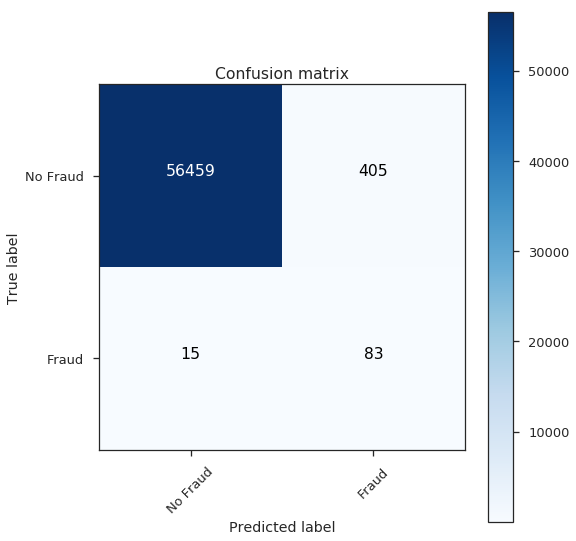

In [32]:
plot_confusion_matrix(model, X_test, y_test, ['No Fraud', 'Fraud'])

Confusion matrix, without normalization
             precision    recall  f1-score   support

   No Fraud       1.00      1.00      1.00   56864.0
      Fraud       0.84      0.77      0.80     196.0

avg / total       1.00      1.00      1.00   57060.0



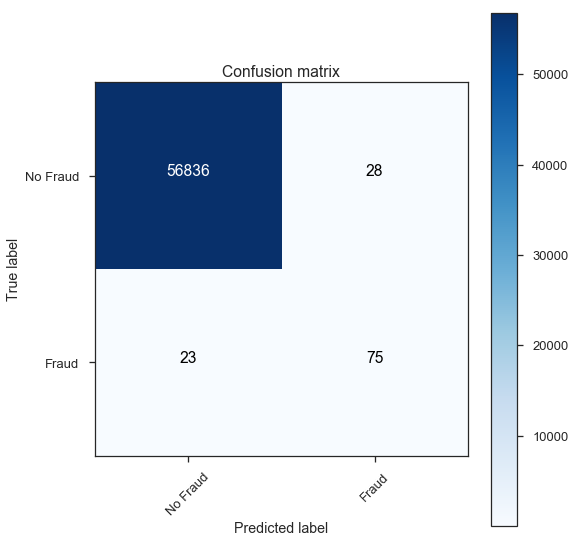

In [248]:
plot_confusion_matrix(model, X_test, y_test, ['No Fraud', 'Fraud'])

In [249]:
cv_score = cross_val_score(model, X_train_val, y_train_val, cv=10, scoring='neg_log_loss')
cv_score.mean(), cv_score.std()

(-0.086501288498674153, 0.00035153641367040832)

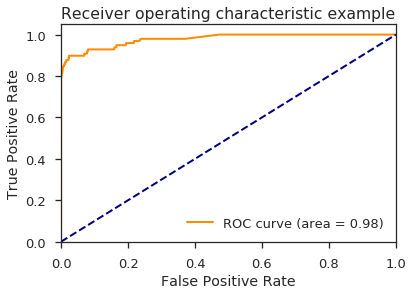

In [33]:
from sklearn.metrics import auc, roc_curve

y_score = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score, sample_weight=y_test+1)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

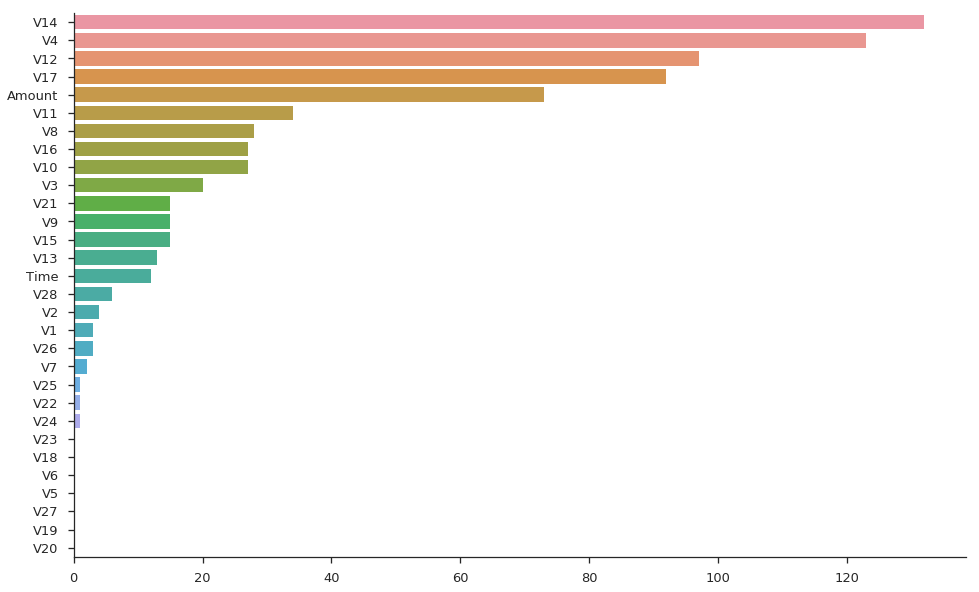

In [34]:
plot_feature_importances(model, X_train)

In [101]:
corr = X_train_val.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

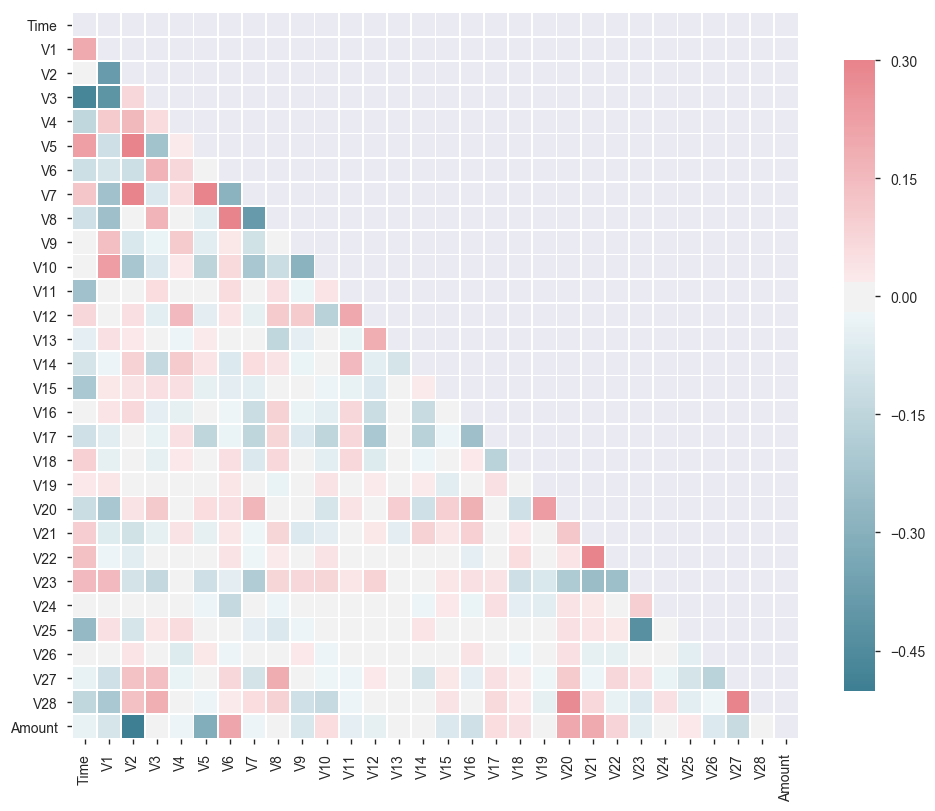

In [102]:
# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={'shrink': 0.65})
plt.tight_layout()